# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

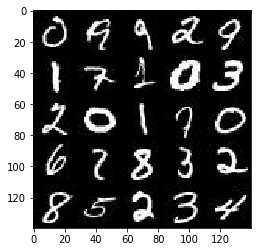

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

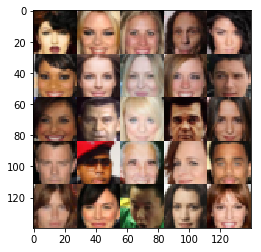

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_r= tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x64
        
        # Output layer
        #print("X3 shape: ", x3.shape)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        #print("logits shape: ", logits.shape)
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
   
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    #From recommendation by slack users nd101.slack.com
        
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha = 0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_r, beta1)
    
    samples, losses = [], []
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *=2.0
                
                # TODO: Train Model
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_r:lr})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_r: lr})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1587... Generator Loss: 2.5454
Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 1.6957
Epoch 1/2... Discriminator Loss: 3.3505... Generator Loss: 2.9500
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 1.2341
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.7543


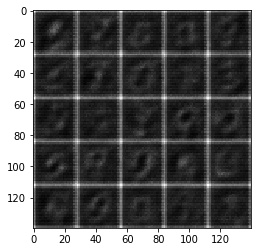

Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.6839
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.9921
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.7294


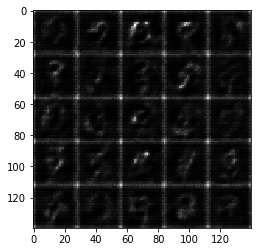

Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 0.7528


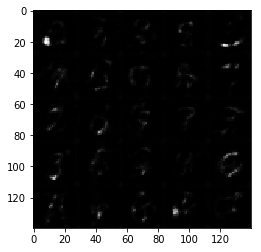

Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 0.9866
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.6839
Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 0.9322
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.1404
Epoch 1/2... Discriminator Loss: 0.8512... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.3886
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 2.0222
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.1883
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.6672


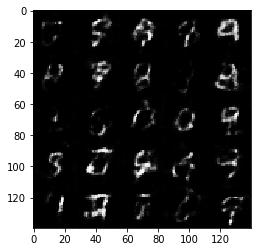

Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.4737
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 1.8272
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.4373
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.4085


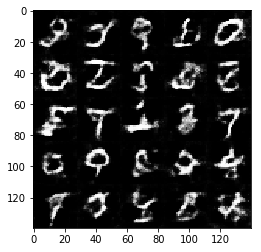

Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 1.6922
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.4453
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 1.1599
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 1.5807
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.4897
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 1.3375


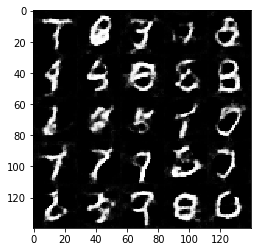

Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.5456
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 1.4254
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.7693


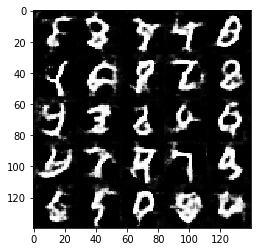

Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 1.3260
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.4893
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.5585


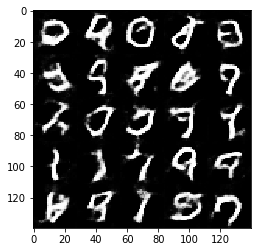

Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 1.3468
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.5848


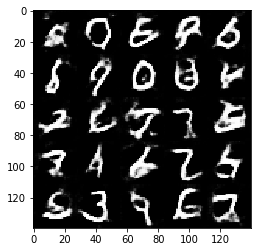

Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 1.6984
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 1.4390
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 0.9735... Generator Loss: 0.9338
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 1.0208... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 1.0752
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.8550


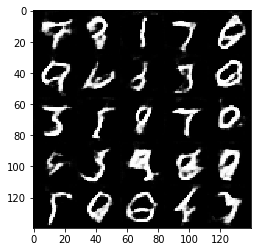

Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.1442
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 1.2045
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 1.2929
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 1.2019
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.5487


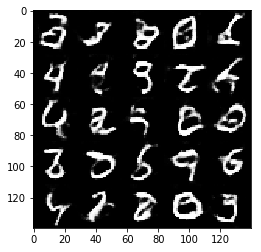

Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 0.8172
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 1.5867
Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 1.1700


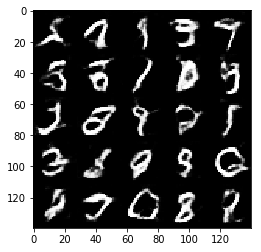

Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.2473
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 0.8026


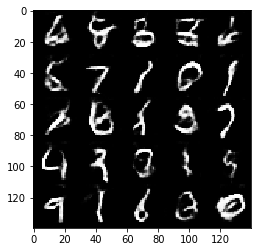

Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 0.3791
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.5400
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.2950
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 0.9971
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.8183


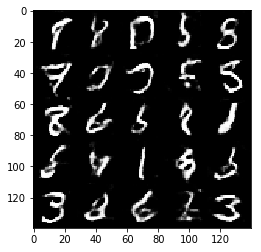

Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 1.3632
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.0987
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.5387
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 0.8075


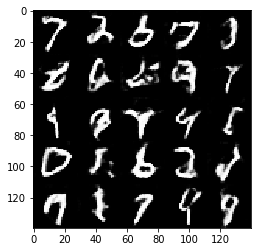

Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.6171
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.4403
Epoch 2/2... Discriminator Loss: 2.0881... Generator Loss: 2.6445
Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.8018


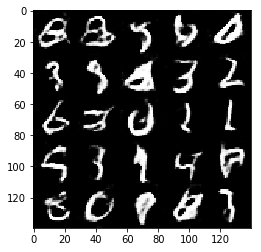

Epoch 2/2... Discriminator Loss: 1.6441... Generator Loss: 2.2186
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 1.0988
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.2982
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 1.7587... Generator Loss: 0.2486
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 1.4802
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 0.9292


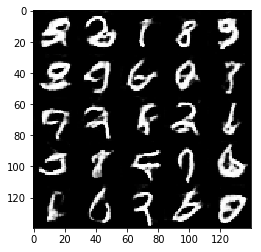

Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.2070
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.3405
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.2493
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.4525
Epoch 2/2... Discriminator Loss: 0.9341... Generator Loss: 1.2857
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 1.2788
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.0668


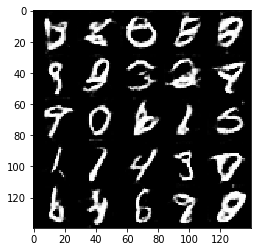

Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 2.2520
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 0.9795
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 0.9435
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.6176


In [ ]:
batch_size = 64
z_dim = 128
lr = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 2.8043
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 4.1453
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 3.2937
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 2.6712
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.6323


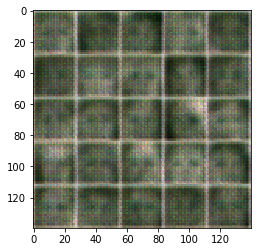

Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.2214
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.8387


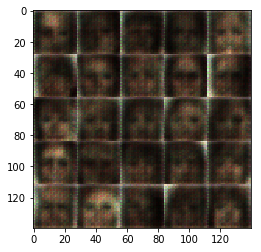

Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 1.5957
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 2.7824
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.5036
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 3.0517
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 3.2037
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 3.6199
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 4.2254


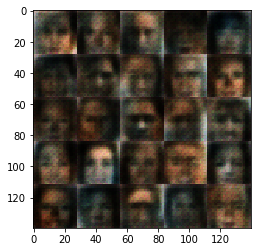

Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 3.9898
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 4.6282
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 4.1693
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.8457
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 2.9656
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 5.3136
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 0.2900... Generator Loss: 2.3877
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 1.7257
Epoch 1/1... Discriminator Loss: 2.0146... Generator Loss: 0.2134


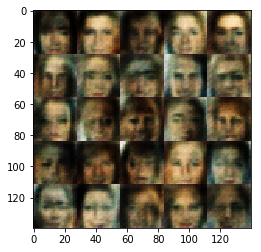

Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 2.1408
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 1.7837
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 3.7787
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.4616


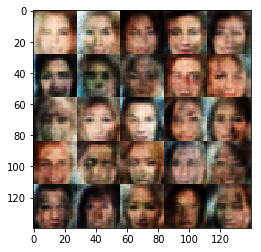

Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 2.6974
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 3.1887
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 4.9443


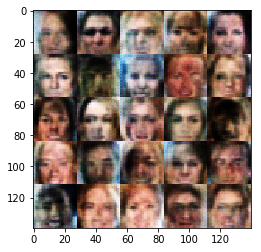

Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 1.9106
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 5.6001
Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 3.3443
Epoch 1/1... Discriminator Loss: 0.2924... Generator Loss: 2.9664
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 5.8550


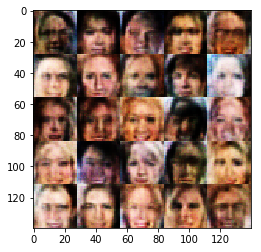

Epoch 1/1... Discriminator Loss: 0.1698... Generator Loss: 3.9783
Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 4.4451
Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 3.0294
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 3.7696
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 4.7151
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 2.1425
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 3.5461
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 4.3149


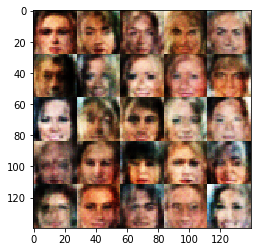

Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 3.9128
Epoch 1/1... Discriminator Loss: 0.2820... Generator Loss: 1.8932
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.3737
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 4.2242
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 5.5312
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 5.0902
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.9103


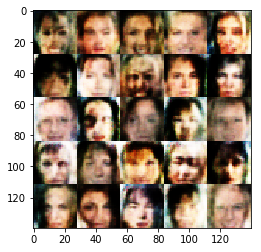

Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 3.3377
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 2.0405
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 4.5379
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 6.1609
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 4.9173
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 3.8828
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.5048


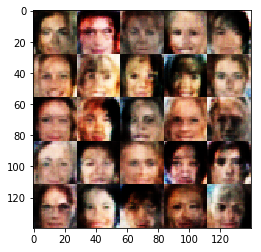

Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 2.8145
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 4.0209
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 1.6449
Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 0.9462


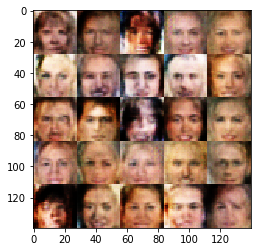

Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 4.4791
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.3377
Epoch 1/1... Discriminator Loss: 0.4288... Generator Loss: 4.2061
Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 2.9674
Epoch 1/1... Discriminator Loss: 2.2238... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.2783


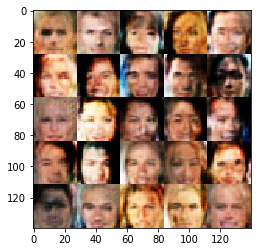

Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 2.5936
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 2.0391
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 1.9540
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 2.9981
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 2.0792
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 2.9859
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 5.2052
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 0.9321


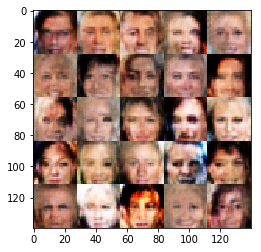

Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 2.3379
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.2688
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.8750... Generator Loss: 3.1359
Epoch 1/1... Discriminator Loss: 0.3182... Generator Loss: 2.3218


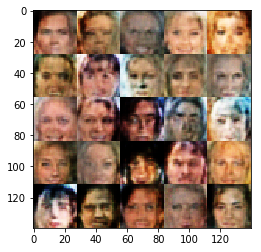

Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.1970
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.6343
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.6355
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 2.4584
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 2.1676
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.2274


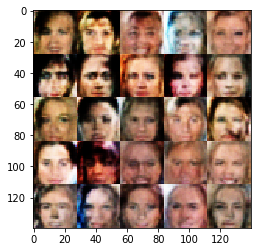

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 1.9742
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 2.5797
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 2.1379
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 1.6604
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 2.1973


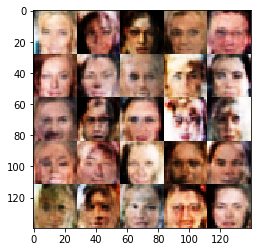

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 2.2536
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.2849
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 0.2570... Generator Loss: 3.4096
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 3.1106
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.2030


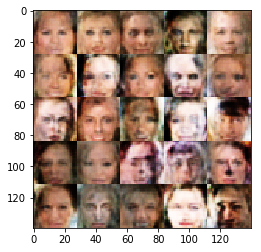

Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 2.2278
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 0.2560... Generator Loss: 3.2001
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.7524


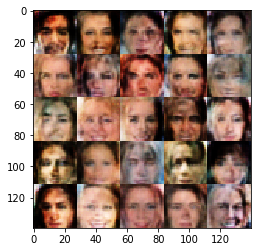

Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 2.8360
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 2.0350
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 1.7621
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 1.9234


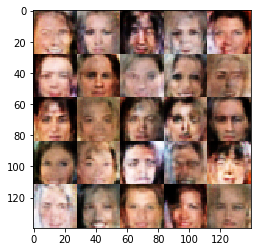

Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.8368
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.0546
Epoch 1/1... Discriminator Loss: 2.0277... Generator Loss: 2.6104
Epoch 1/1... Discriminator Loss: 0.2651... Generator Loss: 3.0777
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 2.1578


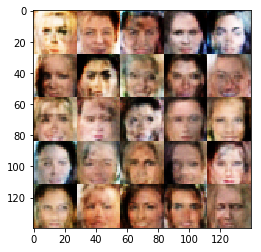

Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.5560
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 2.9445
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 2.0359
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 2.4879
Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 3.4186
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 1.8684


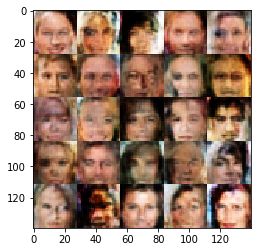

Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.4028
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.6757
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 2.5427
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 3.0418
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.3363


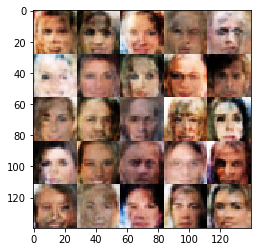

Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 1.6793
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 2.3244
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 2.6116
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 1.6476
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 1.9425
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.0429


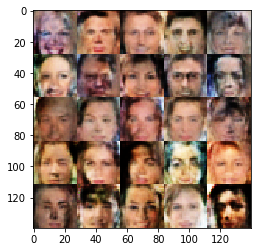

Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 2.6580
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 2.3559
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 1.9407
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.5491
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 2.6962... Generator Loss: 4.5132
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.1929


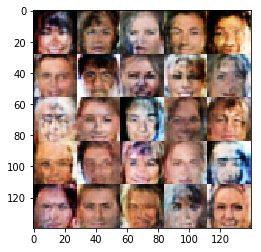

Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.5657
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 1.8513


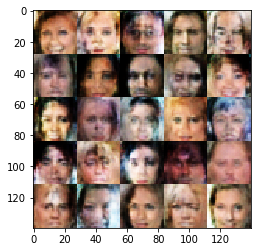

Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 2.0777
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 2.6565
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 1.7704
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.5095
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.3282
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 1.4783


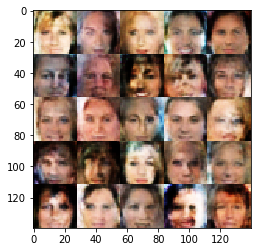

Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 1.9099
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 1.8330
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 2.5113
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 2.1065


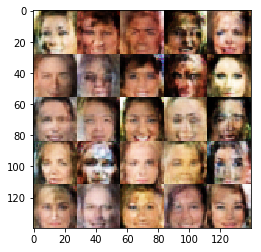

Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 2.0998
Epoch 1/1... Discriminator Loss: 0.2795... Generator Loss: 2.8938
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 3.6709
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 1.7229
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 2.5408
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 1.7004


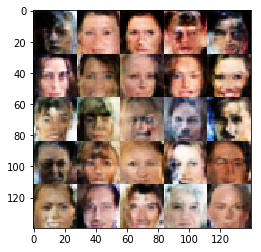

Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.4079
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 2.4680
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.5631
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 1.5738
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 4.1124... Generator Loss: 5.5085
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.0622


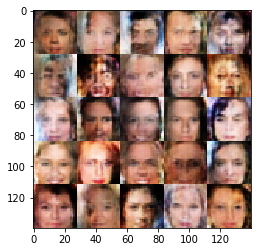

Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 1.4525
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.8875
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 2.2111
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 1.8599
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 2.1850


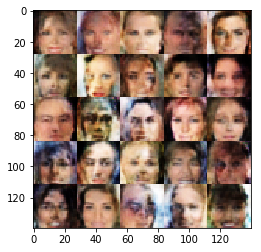

Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.5389
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.8501
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 3.5313
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 2.9737
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.3883


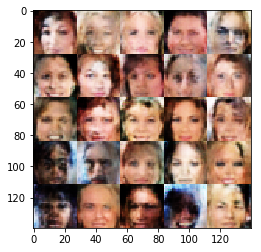

Epoch 1/1... Discriminator Loss: 2.2764... Generator Loss: 0.2566
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 2.1373
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 2.6186


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.